# Prédiction du Prix des Actions avec LSTM (PyTorch)

## Description du Projet

Ce projet implémente un modèle basique de prédiction du prix des actions basé sur l'architecture Long Short-Term Memory (LSTM), un type de réseau de neurones récurrents (RNN) particulièrement efficace pour les données séquentielles comme les séries temporelles financières. Le modèle est développé en utilisant la bibliothèque PyTorch et est capable de prédire le prix de clôture futur d'une action à partir de ses prix passés.


## Technologies Utilisées

*   **Python**
*   **PyTorch** : Pour la construction et l'entraînement du modèle de réseau de neurones.
*   **NumPy** : Pour les opérations numériques.
*   **Pandas** : Pour la manipulation et l'analyse des données.
*   **Matplotlib** : Pour la visualisation des données.
*   **yfinance** : Pour le téléchargement des données boursières.
*   **scikit-learn** : Pour le prétraitement des données (StandardScaler).

## Configuration et Installation

1.  **Cloner le dépôt GitHub (si applicable) :**
    ```bash
    git clone https://github.com/votre_utilisateur/votre_projet.git
    cd votre_projet
    ```

2.  **Installer les dépendances :**
    ```bash
    !pip install pandas numpy matplotlib yfinance scikit-learn torch
    ```
    (Si vous utilisez Google Colab, la plupart sont déjà installées ou peuvent être installées avec cette commande directement dans une cellule de code.)

## Utilisation

1.  **Ouvrir le Notebook** : Ouvrez le fichier `.ipynb` dans un environnement compatible Jupyter (comme Google Colab, Jupyter Lab, ou Jupyter Notebook).
2.  **Exécuter les Cellules** : Exécutez les cellules du notebook séquentiellement. Le code va :
    *   Télécharger les données pour un ticker spécifié (par défaut `AAPL`).
    *   Prétraiter les données.
    *   Construire et entraîner le modèle LSTM.
    *   Évaluer le modèle et afficher les RMSE.
    *   Afficher les graphiques de prédiction.

## Personnalisation

*   **Changer le Ticker de l'Action** : Modifiez la variable `ticker` (par exemple, `'MSFT'`, `'GOOGL'`) dans la cellule appropriée pour analyser une autre action.
*   **Ajuster la Longueur de Séquence (`seq_length`)** : Vous pouvez modifier la variable `seq_length` pour changer le nombre de jours passés que le modèle utilise pour chaque prédiction.
*   **Paramètres du Modèle LSTM** : Ajustez `hidden_size`, `num_layers`, `num_epochs` ou le `lr` (learning rate) pour expérimenter avec différentes configurations de modèle et d'entraînement.

In [57]:

!pip install pandas numpy matplotlib yfinance scikit-learn torch

In [58]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [60]:
ticker = 'AAPL' #Change to others ticker like MSFT to try
df = yf.download(ticker, start='2020-01-01')

/tmp/ipython-input-4021694737.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2020-01-01')
[*********************100%***********************]  1 of 1 completed


In [61]:
df

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.400513,72.460776,71.156674,71.409778,135480400
2020-01-03,71.696655,72.455974,71.472477,71.629160,146322800
2020-01-06,72.267929,72.306499,70.568503,70.819201,118387200
2020-01-07,71.928055,72.533095,71.708695,72.277578,108872000
2020-01-08,73.085098,73.386416,71.631544,71.631544,132079200
...,...,...,...,...,...
2026-02-13,255.779999,262.230011,255.449997,262.010010,56290700
2026-02-17,263.880005,266.290009,255.539993,258.049988,58469100


<Axes: xlabel='Date'>

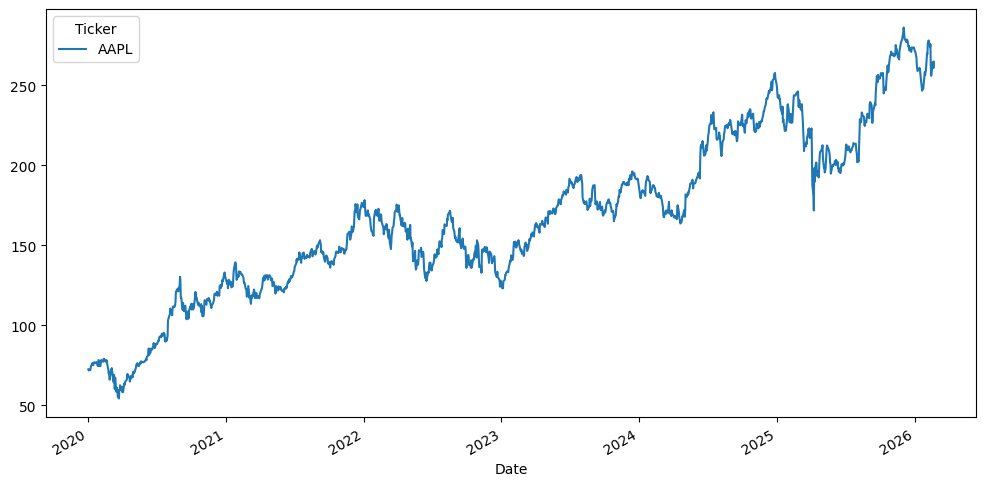

In [62]:
df.Close.plot(figsize=(12, 6))

In [63]:
#preprocessing data
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.847861
2020-01-03,-1.861620
2020-01-06,-1.850453
2020-01-07,-1.857096
2020-01-08,-1.834479
...,...
2026-02-13,1.736715
2026-02-17,1.895049
2026-02-18,1.904236


In [64]:
seq_length = 30 #days
data = []
#sliding windows
for i in range(len(df) - seq_length):
    data.append(df.Close.values[i:i+seq_length])

data = np.array(data)


In [65]:
data

array([[[-1.84786107],
        [-1.8616196 ],
        [-1.85045273],
        ...,
        [-1.7535349 ],
        [-1.71768573],
        [-1.72869064]],

       [[-1.8616196 ],
        [-1.85045273],
        [-1.85709636],
        ...,
        [-1.71768573],
        [-1.72869064],
        [-1.72831318]],

       [[-1.85045273],
        [-1.85709636],
        [-1.83447927],
        ...,
        [-1.72869064],
        [-1.72831318],
        [-1.75641573]],

       ...,

       [[ 1.95623491],
        [ 1.86054207],
        [ 1.82089803],
        ...,
        [ 1.85302213],
        [ 1.73671537],
        [ 1.89504873]],

       [[ 1.86054207],
        [ 1.82089803],
        [ 1.79570629],
        ...,
        [ 1.73671537],
        [ 1.89504873],
        [ 1.90423599]],

       [[ 1.82089803],
        [ 1.79570629],
        [ 1.80215067],
        ...,
        [ 1.89504873],
        [ 1.90423599],
        [ 1.83054224]]])

In [66]:
train_size = int(0.8 * len(data))

#80% training data
X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)

#20% test data
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

In [67]:
#Define LSTM model
class PredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PredictionModel,self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [68]:
model = PredictionModel(input_size=1, hidden_size=64, num_layers=2, output_size=1).to(device)

In [69]:
#loss function
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [70]:
num_epochs = 200

for i in range(num_epochs):
  y_train_pred = model(X_train) # Make a prediction using the model
  loss = criterion(y_train_pred, y_train) # Calculate the loss (how wrong the prediction is)

  if i % 25 == 0:
    print(f'Epoch: {i}, Loss: {loss.item()}') # Print loss every 25 epochs

  optimizer.zero_grad() # Clear previous gradients
  loss.backward() # Compute how much each parameter contributed to the error
  optimizer.step() # Update model parameters using the optimizer

Epoch: 0, Loss: 0.7803799510002136
Epoch: 25, Loss: 0.016670942306518555
Epoch: 50, Loss: 0.005837143864482641
Epoch: 75, Loss: 0.004494814667850733
Epoch: 100, Loss: 0.00412885332480073
Epoch: 125, Loss: 0.003883941099047661
Epoch: 150, Loss: 0.003661214141175151
Epoch: 175, Loss: 0.0034462856128811836


In [71]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())

y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())



In [72]:
train_rmse = root_mean_squared_error(y_train[:,0], y_train_pred[:,0])
test_rmse = root_mean_squared_error(y_test[:,0], y_test_pred[:,0])

In [73]:
print(train_rmse)
print(test_rmse)

2.914529323577881
7.097075939178467


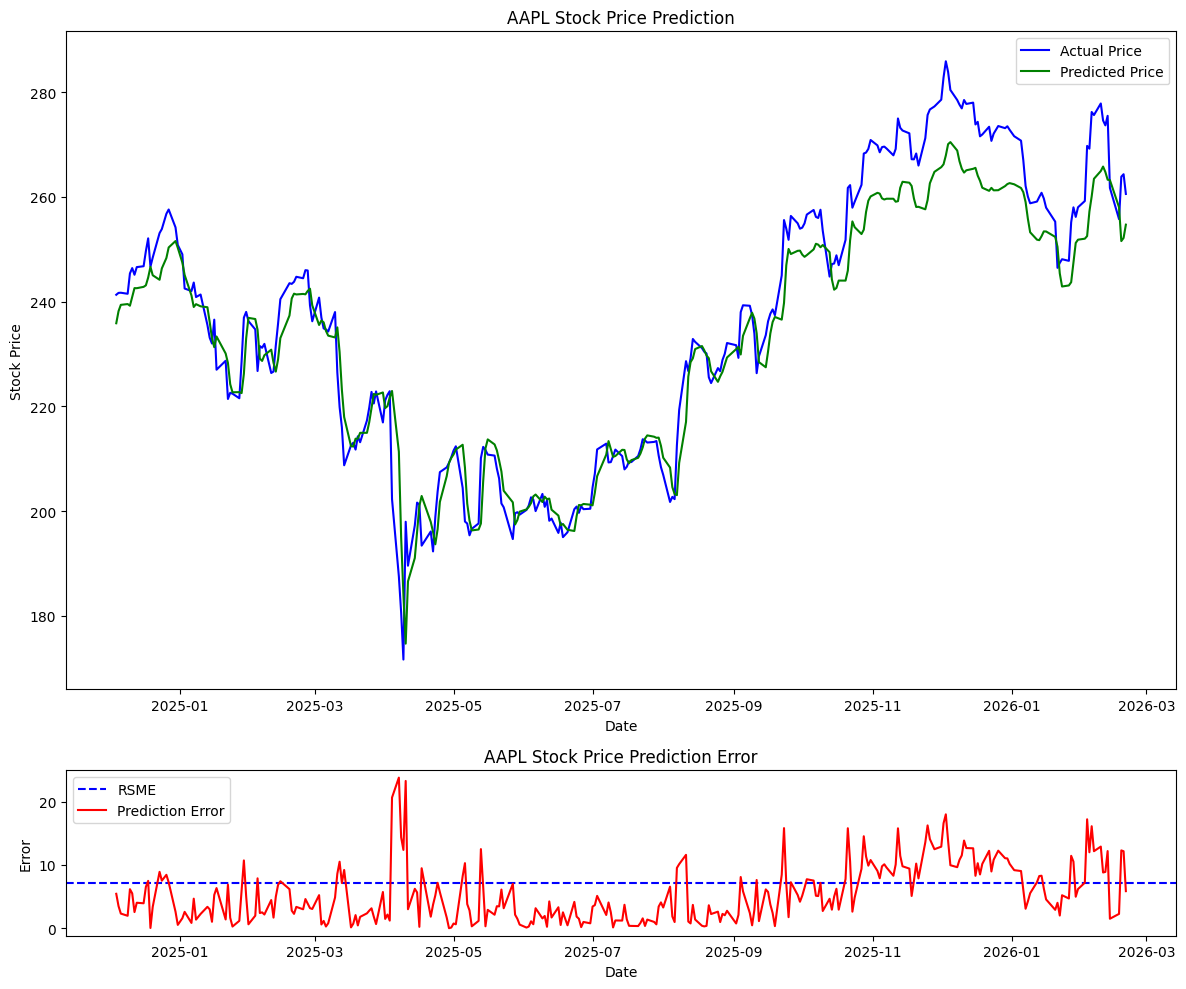

In [74]:
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4,1)
ax1 = fig.add_subplot(gs[:3,0])

ax1.plot(df.iloc[-len(y_test):].index, y_test, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test):].index, y_test_pred, color='green', label='Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")

ax2 = fig.add_subplot(gs[3,0])
ax2.axhline(test_rmse, color = 'blue', linestyle='--', label='RSME')
ax2.plot(df[-len(y_test):].index, abs(y_test-y_test_pred), color='red', label='Prediction Error')
ax2.legend()
plt.title(f"{ticker} Stock Price Prediction Error")
plt.xlabel("Date")
plt.ylabel("Error")

plt.tight_layout()
plt.show()
